# Tunable frequency-bin multi-mode squeezed states of light

This notebook was used to generate plots for the paper entitled "Tunable frequency-bin multi-mode squeezed states of light" by Christian Drago and Agata Branczyk (https://arxiv.org/abs/XXXX.XXXXX)

### Dependencies

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as font_manager
import seaborn as sns
import numdifftools as nd

from custom_poling.core.target import Target
from custom_poling.core.custom_crystal import CustomCrystal
from custom_poling.core.custom_crystal import Crystal
from custom_poling.utils.sellmeier import Sellmeier
from custom_poling.utils.wavenumbers import Wavenumbers
from custom_poling.utils.func_to_matrix import func_to_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Formatting settings

In [3]:
# set the fonts to computer modern
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['font.size']=14

### Phase-matching

In [4]:
# Define the central frequencies of the two downconverted modes and the pump
omega_s_0 = 1265832916458229.0 # signal mode central frequency
omega_i_0 = 1265832916458229.0 # idler mode central frequency
omega_p_0 = omega_s_0 + omega_i_0 # pump mode central frequency

print(f"omega_s_0 = {omega_s_0}")
print(f"omega_i_0 = {omega_i_0}")
print(f"omega_p_0 = {omega_p_0}")

# Generate the Sellmeier equations for KTP
sel_y = Sellmeier(3.0065, 0.03901, 0.04547, 0.01408)
sel_z = Sellmeier(3.3134, 0.05694, 0.05658, 0.01692)

# Generate the wave-vectors as a function of frequency
c=3e8
k_s = lambda omega: omega * sel_z.n(2*np.pi*c*1e6/omega)/c
k_i = lambda omega: omega * sel_y.n(2*np.pi*c*1e6/omega)/c
k_p = lambda omega: omega * sel_y.n(2*np.pi*c*1e6/omega)/c

# Generate the phase-mismatch as a function of downconverted frequencies
delta_k = lambda omega_s,omega_i:k_s(omega_s)+k_i(omega_i)-k_p(omega_s+omega_i)

# Compute the group velocity dispersion at the center frequencies
k_s_gradient = nd.Gradient(k_s,step=1.0e10)([omega_s_0])
k_i_gradient = nd.Gradient(k_i,step=1.0e10)([omega_i_0])
gvd = k_s_gradient-k_i_gradient # group velocity dispersion

print("k_s'-k_i' = ", gvd)

omega_s_0 = 1265832916458229.0
omega_i_0 = 1265832916458229.0
omega_p_0 = 2531665832916458.0
k_s'-k_i' =  3.132950690109289e-10


### The crystal object

In [5]:
# Crystal properties
delta_k_0 = delta_k(omega_s_0,omega_i_0) # central phase-mismatch
domain_width = np.pi/delta_k_0
number_domains = 1073
L=number_domains*domain_width # crystal length

# Numerical integration parameters
k_range = 20000.
k_array = np.linspace(delta_k_0-k_range/2,delta_k_0+k_range,5000)

# Print some parameters
print(f'domain width = {domain_width*1e6} um')
print(f'length = {L*1e2} cm')
print(f'number of domains = {number_domains}')
print(f'k_0 = {delta_k_0} m^-1')
print(f'max amplitude for equivalent periodically-poled crystal = ' + str(2/np.pi))

domain width = 18.629576392710938 um
length = 1.9989535469378836 cm
number of domains = 1073
k_0 = 168634.68000372685 m^-1
max amplitude for equivalent periodically-poled crystal = 0.6366197723675814


### Gaussian functions representing the Phase Matching Function and the Pump Function

In [6]:
# the PMF as a function of wavenumber k
sigma_k = 2.5/L 
del_k = 24*sigma_k
gaussian_term_PMF_k = lambda k,del_k: np.exp(-(k-del_k)**2/(8*sigma_k**2)) # This is a single term, sans the coefficient, in the summation in Eq. (18) of the paper

# the pump as a function of downconverted frequencies
sigma = 2*sigma_k/gvd # Defined in Eq. (19) of the paper
del_omega = 2*del_k/gvd # Defined in Eq. (20) of the paper
gaussian_pump_term_omega = (lambda omega_s,omega_i,delw: 
    np.exp(-(omega_s+omega_i-omega_p_0-delw)**2/(8*sigma**2))/(2*np.pi*sigma**2)**(1/4)) # This is a single term, sans the coefficient, in the summation in Eq. (10) of the paper

### Amplitude gradient upper bound

In [7]:
# Defined in Eq. (21)
gradient_upper_bound = (1/np.pi) * np.sqrt(2*np.pi)/(sigma_k) # note: we exclude a factor of (1/L) from the expression in the paper because the custom_poling package scales the PMF differently to the paper
scale_param = 1/L # note: this will be used later to make up for the excluded (1/L) in the expression above

## 15-MODE SQUEEZED STATE

### Create a 5-peak custom crystal object and compute various properties

In [8]:
# Create a custom crystal object
custom_crystal_5_peaks = CustomCrystal(domain_width,number_domains,z0=-L/2)
domain_middles_5_peaks = custom_crystal_5_peaks.domain_middles

# Specify the coefficients (see Appendix F for how to choose these)
c0 = gradient_upper_bound/4 
c1 = gradient_upper_bound/4
c2 = gradient_upper_bound/4

# Define the target PMF
target_pmf_5_peaks = lambda k: (c2*gaussian_term_PMF_k(k-delta_k_0,-2*del_k) \
                                       + c1*gaussian_term_PMF_k(k-delta_k_0,-del_k) \
                                       + c0*gaussian_term_PMF_k(k-delta_k_0,0) \
                                       + c1*gaussian_term_PMF_k(k-delta_k_0,del_k) \
                                       + c2*gaussian_term_PMF_k(k-delta_k_0,2*del_k))
target_5_peaks = Target(target_pmf_5_peaks,k_array)

# Compute the target amplitude
target_amplitude_5_peaks = target_5_peaks.compute_amplitude(delta_k_0,domain_middles_5_peaks,z0=-L/2)

# Compute the custom domains
custom_domains_5_peaks = custom_crystal_5_peaks.compute_domains(target_amplitude_5_peaks,delta_k_0)

# Compute the PMF for the cystomized crystal
pmf_custom_crystal_5_peaks = custom_crystal_5_peaks.compute_pmf(k_array);

# Compute the amplitude for the cystomized crystal
custom_amplitude_5, z_list_5 = custom_crystal_5_peaks.compute_amplitude(delta_k_0,num_internal_points=1)

### Fig 1 (Main text)

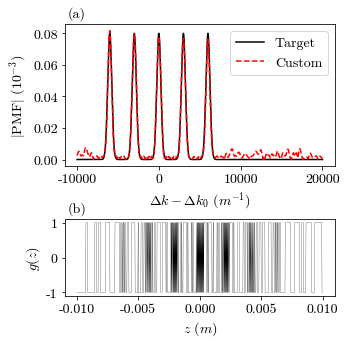

In [9]:
# Prepare multipanel plot 
fig = plt.figure(1, figsize=(5, 5))
gs = gridspec.GridSpec(5,5)
gs.update(wspace=10, hspace=4.5)

# Generate first panel
xtr_subsplot= fig.add_subplot(gs[0:3,0:5])
plt.plot(k_array-delta_k_0, scale_param * np.abs(target_5_peaks.pmf), linestyle='-', label='Target', mfc='w', markersize=8,color='k')
plt.plot(k_array-delta_k_0, scale_param * np.abs(pmf_custom_crystal_5_peaks), linestyle='--', label='Custom', markerfacecolor='w', markersize=8,color='r')
plt.legend(loc='upper right')
plt.xlabel(r'$\Delta k-\Delta k_0~(m^{-1})$')
plt.ylabel(r'$|$PMF$|$ ($10^{-3}$)')

# Generate second panel
xtr_subsplot = fig.add_subplot(gs[3:5,0:5])
plt.plot(custom_crystal_5_peaks.domain_walls, np.concatenate(([custom_crystal_5_peaks.domain_configuration[0]],custom_crystal_5_peaks.domain_configuration)), linestyle='-', label='Target2', mfc='w', markersize=8,color='k',linewidth = 0.25)
plt.xlabel(r'$z~(m)$')
plt.ylabel(r'$g(z)$')
plt.gcf().subplots_adjust(left=0.15)

# Figure labels
plt.text(-0.0108, 6.9, "(a)")
plt.text(-0.0108, 1.3, "(b)")

# Show plot
plt.show()

### Figure 2

In [10]:
# Plotting parameters
omega_range_5_peaks = 1e14
omega_s_5_peaks = np.linspace(omega_s_0 - omega_range_5_peaks/2,omega_s_0 + omega_range_5_peaks/2, 200)
omega_i_5_peaks = np.linspace(omega_i_0 - omega_range_5_peaks/2,omega_i_0 + omega_range_5_peaks/2, 200)

# PMF as a function of frequency
delta_k_5_peaks_omega = np.array(func_to_matrix(delta_k,omega_s_5_peaks,omega_i_5_peaks))
pmf_5_peaks_omega = custom_crystal_5_peaks.compute_pmf(delta_k_5_peaks_omega)

pump_5_peaks_func = lambda omega_s,omega_i: gaussian_pump_term_omega(omega_s,omega_i,-2*del_omega) \
                            + gaussian_pump_term_omega(omega_s,omega_i,-del_omega) \
                            + gaussian_pump_term_omega(omega_s,omega_i,0) \
                            + gaussian_pump_term_omega(omega_s,omega_i,del_omega) \
                            + gaussian_pump_term_omega(omega_s,omega_i,2*del_omega)
pump_5_peaks_omega = func_to_matrix(pump_5_peaks_func,omega_s_5_peaks,omega_i_5_peaks)

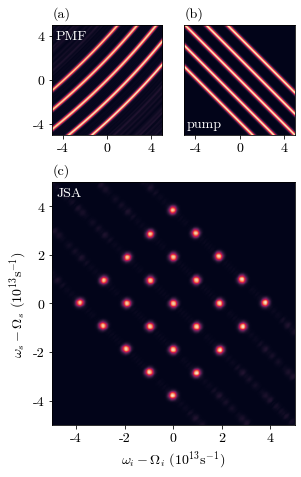

In [11]:
colormp = sns.color_palette("rocket", as_cmap=True)

xticks3 = np.arange(-4,4.1,2)
yticks3 = np.arange(-4,4.1,2)
xticks4 = np.arange(-4,4.1,4)
yticks4 = np.arange(-4,4.1,4)

# Prepare multipanel plot 
fig = plt.figure(2, figsize=(5, 8))
gs = gridspec.GridSpec(6,4)
gs.update(wspace=0.5, hspace=0.2)

#Generate first panel
xtr_subsplot= fig.add_subplot(gs[2:6,0:4])
plt.imshow(np.abs(pump_5_peaks_omega*pmf_5_peaks_omega),origin='lower',extent=[(omega_s_5_peaks[0]-omega_i_0)*1e-13,(omega_s_5_peaks[-1]-omega_i_0)*1e-13,(omega_s_5_peaks[0]-omega_s_0)*1e-13,(omega_s_5_peaks[-1]-omega_s_0)*1e-13],cmap=colormp);
plt.xticks(xticks3)
plt.yticks(yticks3)
plt.xlabel(r'$\omega_i-\Omega_i~$(10$^{13}$s$^{-1}$)')
plt.ylabel(r'$\omega_s-\Omega_s~$(10$^{13}$s$^{-1}$)')
plt.text(-4.8, 4.4, "JSA", color='white')

# Generate second panel
xtr_subsplot = fig.add_subplot(gs[0:2,0:2])
plt.imshow(np.abs(pmf_5_peaks_omega),origin='lower',extent=[(omega_s_5_peaks[0]-omega_i_0)*1e-13,(omega_s_5_peaks[-1]-omega_i_0)*1e-13,(omega_s_5_peaks[0]-omega_s_0)*1e-13,(omega_s_5_peaks[-1]-omega_s_0)*1e-13],cmap=colormp);
plt.xticks(xticks4)
plt.yticks(yticks4)
plt.text(-4.7, 3.7, "PMF", color='white')

# Generate third panel
xtr_subsplot = fig.add_subplot(gs[0:2,2:4])
im=plt.imshow(np.abs(pump_5_peaks_omega),origin='lower',extent=[(omega_s_5_peaks[0]-omega_i_0)*1e-13,(omega_s_5_peaks[-1]-omega_i_0)*1e-13,(omega_s_5_peaks[0]-omega_s_0)*1e-13,(omega_s_5_peaks[-1]-omega_s_0)*1e-13],cmap=colormp);
plt.xticks(xticks4)
plt.yticks([-10])
plt.text(-4.8, -4.3, "pump", color='white')

fig.subplots_adjust(right=0.8)

# Figure labels
plt.text(-16.9, 5.7, "(a)")
plt.text(-5.0, 5.7, "(b)")
plt.text(-16.9, -8.5, "(c)")

# Show plot
plt.show()

### Figure 4 (a-b)

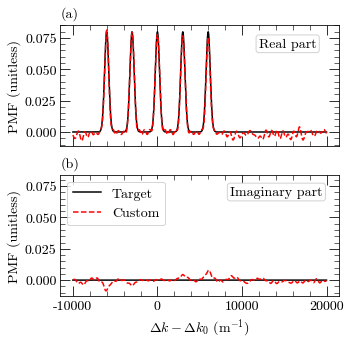

In [12]:
# Prepare multipanel plot 
fig = plt.figure(1, figsize=(5, 5))
gs = gridspec.GridSpec(4,4)
gs.update(wspace=1, hspace=.6)

# Generate first panel
xtr_subsplot= fig.add_subplot(gs[0:2,0:4])
plt.plot(k_array-delta_k_0, scale_param*np.real(target_5_peaks.pmf), linestyle='-', label='Target', mfc='w', markersize=8,color='k')
plt.plot(k_array-delta_k_0, scale_param*np.real(pmf_custom_crystal_5_peaks), linestyle='--', label='Custom', markerfacecolor='w', markersize=8,color='r')
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=10, bottom=True, top=True, left=True, right=True)
plt.text(12000, scale_param*c2*0.85, "Real part", color='black', bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.2'))
xtr_subsplot.axes.get_xaxis().set_ticklabels([])
plt.ylabel(r'PMF (unitless)')

# Generate second panel
xtr_subsplot= fig.add_subplot(gs[2:4,0:4])
plt.plot(k_array-delta_k_0, scale_param*np.real(target_5_peaks.pmf), mfc='w', markersize=8,color="white")
plt.plot(k_array-delta_k_0, scale_param*np.imag(target_5_peaks.pmf), linestyle='-', label='Target', mfc='w', markersize=8,color='k')
plt.plot(k_array-delta_k_0, scale_param*np.imag(pmf_custom_crystal_5_peaks), linestyle='--', label='Custom', markerfacecolor='w', markersize=8,color='r')
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=10, bottom=True, top=True, left=True, right=True)
plt.text(8600, scale_param*c2*0.85, "Imaginary part", color='black', bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.2'))
plt.legend(loc='upper left')
plt.xlabel(r'$\Delta k-\Delta k_0~$(m$^{-1}$)')
plt.ylabel(r'PMF (unitless)')

# Figure labels
plt.text(-11500 ,0.21, "(a)")
plt.text(-11500, 0.09, "(b)")


# Show plot
plt.show()

### Figure 4 (c-d)

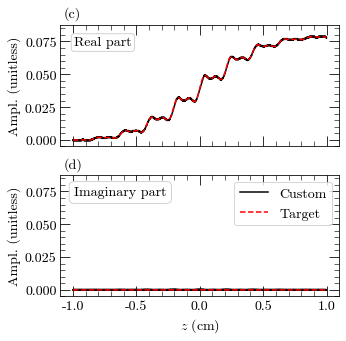

In [13]:
# Prepare multipanel plot 
fig = plt.figure(1, figsize=(5, 5))
gs = gridspec.GridSpec(4,4)
gs.update(wspace=1, hspace=.6)

# Generate first panel
xtr_subsplot= fig.add_subplot(gs[0:2,0:4])
plt.plot(np.array(z_list_5)*100, scale_param*np.real(custom_amplitude_5), linestyle='-', label='Custom\nPMF', markerfacecolor='w', markersize=8,color='k')
plt.plot(custom_crystal_5_peaks.domain_middles*100, scale_param*np.real(target_5_peaks.amplitude), linestyle='--', label='Target\nPMF', mfc='w', markersize=8,color='r')
xticks = np.arange(-100*L/2,100*L/2+0.1,100*L/2)
yticks = np.arange(-0,scale_param*c0*1.1,scale_param*0.0005)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=10, bottom=True, top=True, left=True, right=True)
plt.ylim([-scale_param*0.0001, scale_param*c0*1.1])
plt.text(-0.99, scale_param*c0*0.9, "Real part", color='black', bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.2'))
xtr_subsplot.axes.get_xaxis().set_ticklabels([])
plt.ylabel(r'Ampl. (unitless)')

# Generate second panel
xtr_subsplot= fig.add_subplot(gs[2:4,0:4])
plt.plot(np.array(z_list_5)*100, scale_param*np.imag(custom_amplitude_5), linestyle='-', label='Custom', markerfacecolor='w', markersize=8,color='k')
plt.plot(custom_crystal_5_peaks.domain_middles*100, scale_param*np.imag(target_5_peaks.amplitude), linestyle='--', label='Target', mfc='w', markersize=8,color='r')
xticks = np.arange(-100*L/2,100*L/2+0.1,100*L/2)
yticks = np.arange(-0,scale_param*c0*1.1,scale_param*0.0005)
plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=10, bottom=True, top=True, left=True, right=True)
plt.ylim([-scale_param*0.0001, scale_param*c0*1.1])
plt.legend(loc='upper right')
plt.xlabel(r'$z~$(cm)')
plt.ylabel(r'Ampl. (unitless)')
plt.text(-0.99, scale_param*c0*0.9, "Imaginary part", color='black', bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.35'))

# Figure labels
plt.text(-1.07 ,0.208, "(c)")
plt.text(-1.07, 0.093, "(d)")

# Show plot
plt.show()

## TUNABLE HYBRID SQUEEZED STATES

### Create a 3-peak custom crystal object and compute various properties

In [14]:
# Create a custom crystal object
custom_crystal_3_peaks = CustomCrystal(domain_width,number_domains,z0=-L/2)
domain_middles_3_peaks = custom_crystal_5_peaks.domain_middles

#Define and plot the target function
c0 = gradient_upper_bound/4
c1 = 3*gradient_upper_bound/8

target_pmf_3_peaks = lambda k: (c1*gaussian_term_PMF_k(k-delta_k_0,-del_k) \
                                       + c0*gaussian_term_PMF_k(k-delta_k_0,0) \
                                       + c1*gaussian_term_PMF_k(k-delta_k_0,del_k))
target_3_peaks = Target(target_pmf_3_peaks,k_array)

# Compute the target amplitude
target_amplitude_3_peaks = target_3_peaks.compute_amplitude(delta_k_0,domain_middles_3_peaks,z0=-L/2)

# Compute the custom domains
custom_domains_3_peaks = custom_crystal_3_peaks.compute_domains(target_amplitude_3_peaks,delta_k_0)

# Compute the PMF for the cystomized crystal
pmf_custom_crystal_3_peaks = custom_crystal_3_peaks.compute_pmf(k_array);

# Compute the amplitude for the cystomized crystal
custom_amplitude_3, z_list_3 = custom_crystal_3_peaks.compute_amplitude(delta_k_0,num_internal_points=1)

### Figure 3 (a-b)

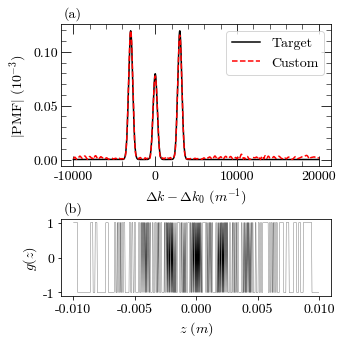

In [15]:
#Prepare multipanel plot 
fig = plt.figure(1, figsize=(5, 5))
gs = gridspec.GridSpec(5,5)
gs.update(wspace=10, hspace=4.5)

#Generate first panel
xtr_subsplot= fig.add_subplot(gs[0:3,0:5])

plt.plot(k_array-delta_k_0, scale_param*np.abs(target_3_peaks.pmf), linestyle='-', label='Target', mfc='w', markersize=8,color='k')
plt.plot(k_array-delta_k_0, scale_param*np.abs(pmf_custom_crystal_3_peaks), linestyle='--', label='Custom', markerfacecolor='w', markersize=8,color='r')

# xticks = np.arange(-10000,15001,5000)
# yticks = np.arange(0,scale_param*c1*1.1,scale_param*0.0005)

plt.minorticks_on()
plt.tick_params(direction='in',which='minor', length=5, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=10, bottom=True, top=True, left=True, right=True)
# plt.xticks(xticks)
# plt.yticks(yticks)

plt.legend(loc='upper right')

plt.xlabel(r'$\Delta k-\Delta k_0~(m^{-1})$')
plt.ylabel(r'$|$PMF$|$ ($10^{-3}$)')

#generate second panel
xtr_subsplot = fig.add_subplot(gs[3:5,0:5])

plt.plot(custom_crystal_3_peaks.domain_walls, np.concatenate(([custom_crystal_3_peaks.domain_configuration[0]],custom_crystal_3_peaks.domain_configuration)), linestyle='-', label='Target2', mfc='w', markersize=8,color='k',linewidth = 0.25)

plt.xlabel(r'$z~(m)$')
plt.ylabel(r'$g(z)$')

plt.gcf().subplots_adjust(left=0.15)

# Figure labels
plt.text(-0.0108, 6.9, "(a)")
plt.text(-0.0108, 1.3, "(b)")

# Show plot
plt.show()

### Figure 3 (c)

In [16]:
# Specify the plotting parameters
omega_range_3_peaks = 6e13
omega_s3_peaks = np.linspace(omega_s_0 - omega_range_3_peaks/2,omega_s_0 + omega_range_3_peaks/2, 200)
omega_2_3_peaks = np.linspace(omega_i_0 - omega_range_3_peaks/2,omega_i_0 + omega_range_3_peaks/2, 200)

# Compute the PMF as a function of frequency
delta_k_3_peaks_omega = np.array(func_to_matrix(delta_k,omega_s3_peaks,omega_2_3_peaks))
pmf_3_peaks_omega = custom_crystal_3_peaks.compute_pmf(delta_k_3_peaks_omega)

pump_3_peaks_func = lambda omega_s,omega_i: (gaussian_pump_term_omega(omega_s,omega_i,-del_omega) \
                            + gaussian_pump_term_omega(omega_s,omega_i,0) \
                            + gaussian_pump_term_omega(omega_s,omega_i,del_omega))
pump_3_peaks_omega = func_to_matrix(pump_3_peaks_func,omega_s3_peaks,omega_2_3_peaks)

# compute the filter function
sigma_filter = 2*sigma
filter_func = lambda omega_s,omega_i: (1-np.exp(-(((omega_s-omega_s_0)**2/(4*sigma_filter**2)))))*(1-np.exp(-(((omega_i-omega_i_0)**2/(4*sigma_filter**2)))))
filter_omega = func_to_matrix(filter_func,omega_s3_peaks,omega_2_3_peaks)

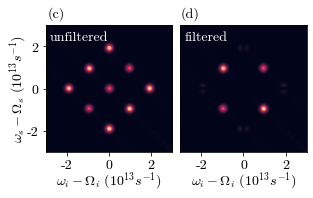

In [17]:
xticks3 = np.arange(-2,2.1,2)
yticks3 = np.arange(-2,2.1,2)
xticks4 = np.arange(-2,2.1,2)
yticks4 = np.arange(-2,2.1,2)

# Prepare multipanel plot 
fig = plt.figure(2, figsize=(5, 3))
gs = gridspec.GridSpec(4,8)
gs.update(wspace=0.3, hspace=0.5)

# Generate first panel
xtr_subsplot= fig.add_subplot(gs[0:4,0:4])

im=plt.imshow(np.abs(pump_3_peaks_omega*pmf_3_peaks_omega),origin='lower',extent=[(omega_2_3_peaks[0]-omega_i_0)*1e-13,(omega_2_3_peaks[-1]-omega_i_0)*1e-13,(omega_s3_peaks[0]-omega_s_0)*1e-13,(omega_s3_peaks[-1]-omega_s_0)*1e-13],cmap=colormp);
plt.xticks(xticks3)
plt.yticks(yticks3)
plt.text(-2.8, 2.3, "unfiltered", color='white')
plt.xlabel(r'$\omega_i-\Omega_i ~(10^{13}s^{-1})$',labelpad=-2)
plt.ylabel(r'$\omega_s-\Omega_s~(10^{13}s^{-1})$',labelpad=-2)
#labelpad=-4

#generate second panel
xtr_subsplot= fig.add_subplot(gs[0:4,4:8])

plt.imshow(np.abs(pump_3_peaks_omega*pmf_3_peaks_omega*filter_omega),origin='lower',extent=[(omega_2_3_peaks[0]-omega_i_0)*1e-13,(omega_2_3_peaks[-1]-omega_i_0)*1e-13,(omega_s3_peaks[0]-omega_s_0)*1e-13,(omega_s3_peaks[-1]-omega_s_0)*1e-13],cmap=colormp);
plt.xticks(xticks3)
plt.yticks([-10])
plt.text(-2.8, 2.3, "filtered", color='white')
plt.xlabel(r'$\omega_i-\Omega_i ~(10^{13}s^{-1})$',labelpad=-2)

#generate colorbar
fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.87, 0.17, 0.02, 0.66])
# fig.colorbar(im, cax=cbar_ax)

# Figure labels
plt.text(-9.3, 3.4, "(c)")
plt.text(-3.0, 3.4, "(d)")

# Show plot
plt.show()